# Real vs Fake News

**About**     
Build a classification model to determine if an news article is fake or real ?

<p><img src="resources/real_fake.jpg" style="width: 500px"></p>

**Data**   
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

## Exploratory Data Analysis

### 1. Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import re
import nltk
#Download packages if not downloaded
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

### 2. Load Data

After loading and going for in-depth analysis, the head of the dataset is observed to get a glimpse of different variables.

In [2]:
zf = zipfile.ZipFile('datasets/news.zip')
fake_news = pd.read_csv(zf.open('Fake.csv'))
real_news = pd.read_csv(zf.open('True.csv'))
real_news.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake_news.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


#### Merging Real and Fake News into one dataframe

In [4]:
real_news['newsType']="Real"
fake_news['newsType']="Fake"

news_raw = pd.concat([real_news, fake_news], axis=0)
news_raw.head(10)

,title,text,subject,date,newsType
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",Real
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",Real
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",Real
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",Real
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",Real


## Data Visualization

### A. News By Subject

The graph shows that polticsNews is the leading news 'subject' and Middle-east is at the bottom of the chart.

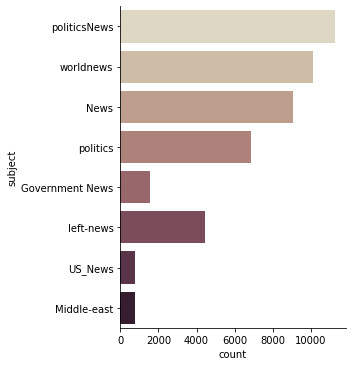

In [5]:
sns.catplot(y="subject", kind="count", palette="ch:.35", data=news_raw)

### B. Real vs Fake News

The dataset is balanced with similar number of real and fake news

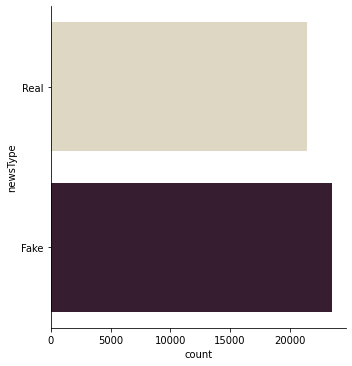

In [6]:
sns.catplot(y="newsType", kind="count", palette="ch:.35", data=news_raw)

### C. Fake News Word Cloud

'Donald Trump', 'Featured image', 'one','said' occurs frequently in fake news.

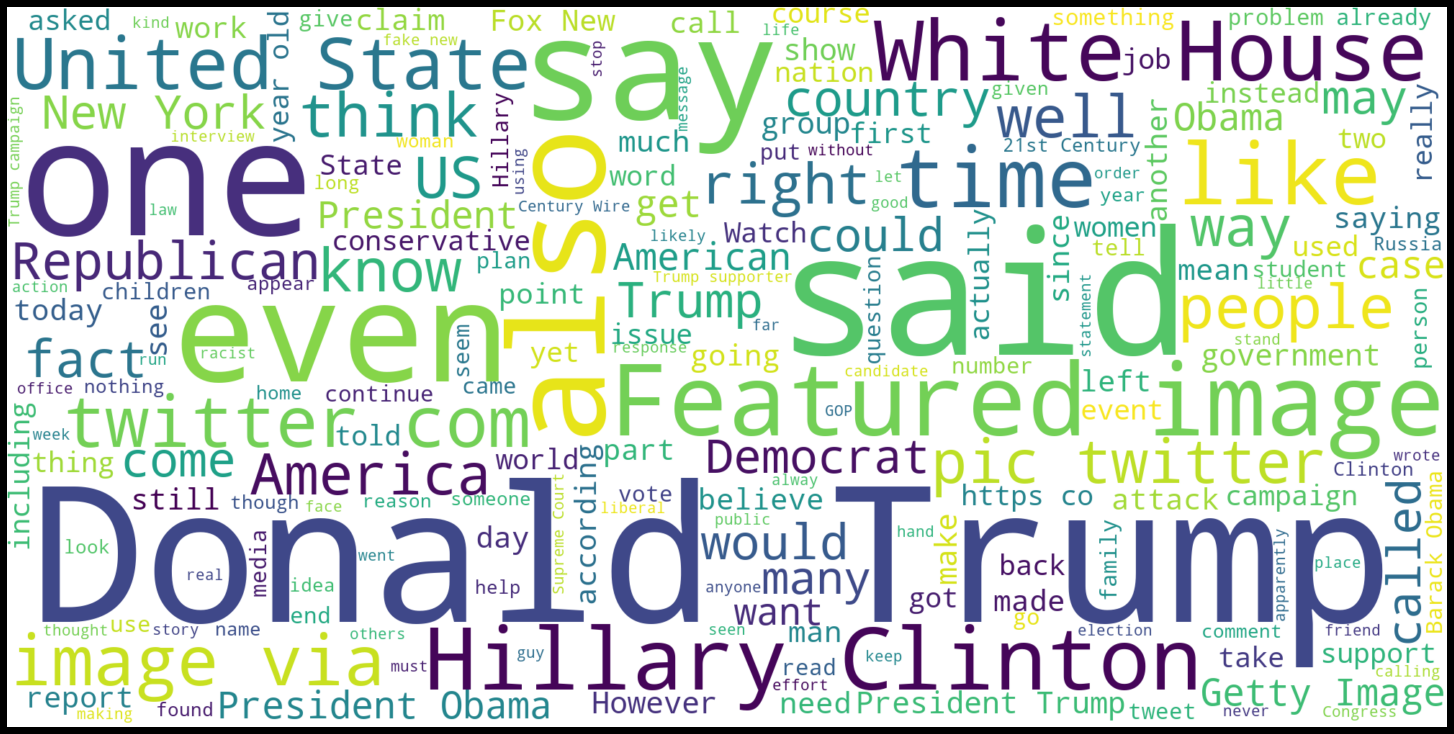

In [7]:
def plotWordCloud(df,columnName):
    text = ''
    stopwords = set(nltk.corpus.stopwords.words("english"))
    for news in df[columnName].values:
        text += f" {news}"
    wordcloud = WordCloud(width = 2000,height = 1000,background_color = 'white',stopwords = stopwords).generate(text)
    fig = plt.figure(figsize = (20, 15),facecolor = 'k',edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

plotWordCloud(fake_news,'text')

### D. Real News Word Cloud

Donald Trump, White House, Washington, United States occurs frequently in real news. This can be stated to the fact that this dataset has more articles on politics than in any other category

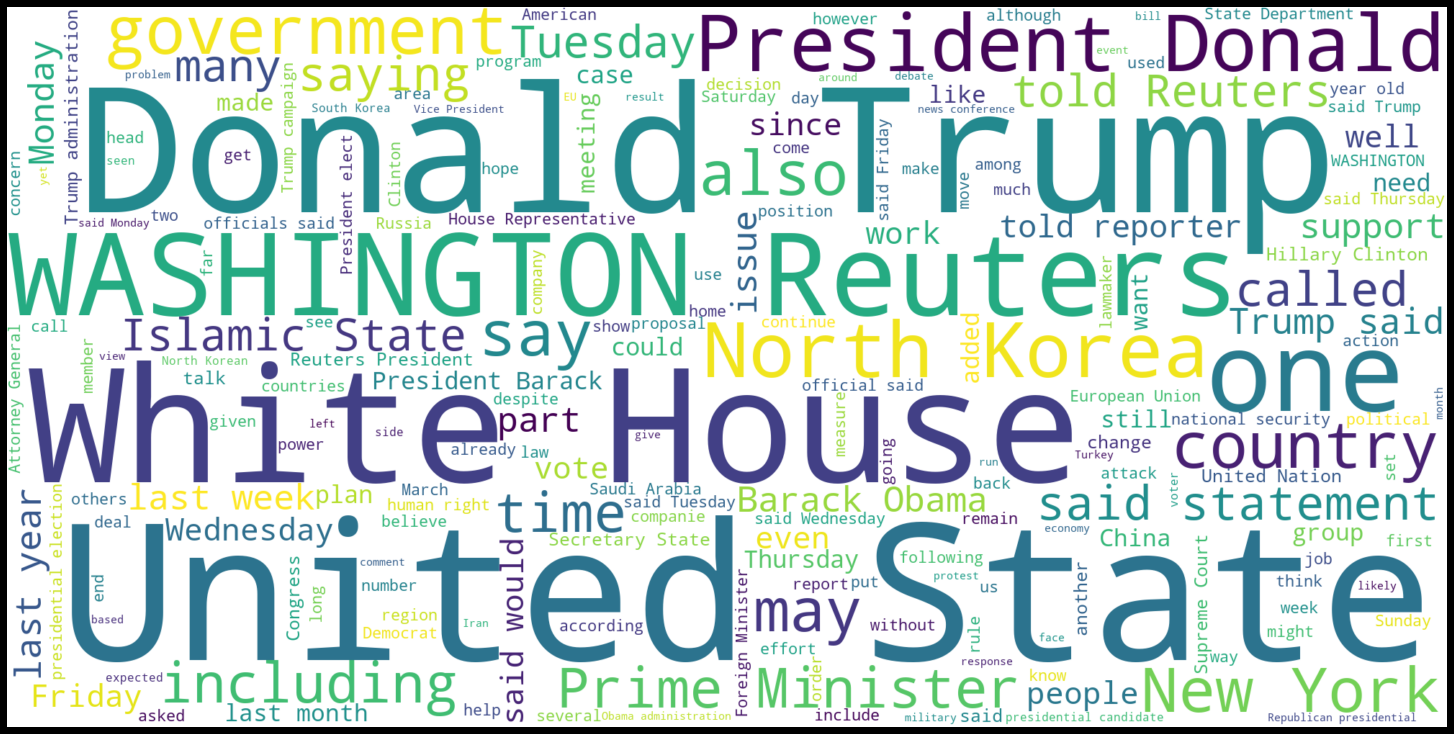

In [8]:
plotWordCloud(real_news,'text')

### Combining title and text and dropping unnecessary columns

In [9]:
# Denote Real by 1 and Fake by 0
news_raw['newsType'] = news_raw['newsType'].apply(lambda x: 1 if (x == 'Real') else 0)

# Combining title and text
news_raw['fulltext'] = news_raw.title + ' ' + news_raw.text
news_raw.drop(['title','text'], axis=1, inplace=True)

# Copy contents in a new dataframe
news = news_raw[['fulltext', 'newsType']]
news = news.reset_index()
news.drop(['index'], axis=1, inplace=True)

### 3. Check for data dimensions

In [10]:
news.shape

(44898, 2)

### 4. Check variable datatypes

newsType is a binary variable with 1 meaning Real News and 0 meaning fake news

In [11]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
fulltext    44898 non-null object
newsType    44898 non-null int64
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


### 5. Check for missing values

Missing article text can be either NaN or empty string

#### Detect & remove NaN values:

In [12]:
#Checking missing values : percentage
def computeMissingPercent(df):
    missing_values = (df.isnull().sum() / len(df) * 100)
    missdf = missing_values.to_frame()
    missdf.columns = ['Missing_Percent']
    return missdf

computeMissingPercent(news).sort_values(by=['Missing_Percent'],ascending=False)

,Missing_Percent
fulltext,0.0
newsType,0.0


#### Detect & remove empty strings

In [13]:
blanks = []
for i,rv,lb in news.itertuples(): 
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'article' for whitespace
            blanks.append(i)     # add matching index numbers to the list

news.drop(blanks, inplace=True)
print(str(len(blanks)) + ' blanks were removed')

0 blanks were removed


## Data Preprocessing (Cleaning and Feature Engineering)

#### 1. Remove 'http' prefix

In [14]:
def removeHttpPrefix(textString):
    return re.sub(r'http\S+', '', textString)

news['fulltext']=news['fulltext'].apply(removeHttpPrefix)

#### 2. Remove stopwords

In [15]:
def removeStopwords(textString):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    cleanedString = pattern.sub(' ', textString)
    return cleanedString
    
news['fulltext']=news['fulltext'].apply(removeStopwords)

#### 3. Remove punctuations

In [16]:
def removePunctuations(textString):
    lowerString = textString.lower()
    translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
    cleanedString = lowerString.translate(translation_table)
    return cleanedString
    
news['fulltext']=news['fulltext'].apply(removePunctuations)

#### 4. Lemmatization

In [17]:
lemmatizer = WordNetLemmatizer()
def lemmatizeWords(textString):
    words = lemmatizer.lemmatize(textString)
    return words

news['fulltext']=news['fulltext'].apply(lemmatizeWords)

## Model Development

Build pipelines to vectorize the data, then train and fit a model

### Train/Test Split

In [18]:
# Preparing training and testing data using train_test_split
X_data = news['fulltext']
y_data = news['newsType']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state= 234)

### Multinomial NB

We will start with by building a pipeline for Multinomial Naive Baiyes model. 

* The first step of the pipeline would to convert raw documents in to a matrix of TF-IDF features.
* Instatiate an instance of Multinomial Naive Baiyes model

In [19]:
# Multinomial Naive Bayes:
text_clf_mnb = Pipeline([('tfidf_news', TfidfVectorizer()),
                     ('mnb', MultinomialNB()),
])

text_clf_mnb.fit(X_train, y_train)

# Form a prediction set
predictions = text_clf_mnb.predict(X_test)

# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[5691  256]
 [ 355 4923]]


In [20]:
mnb_f1_score = f1_score(y_test, predictions)
mnb_accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy : {round(mnb_accuracy,4)}")
print(f"F1-Score : {round(mnb_f1_score,4)}")
# Print a classification report
print(metrics.classification_report(y_test,predictions))

Accuracy : 0.9456
F1-Score : 0.9416
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5947
           1       0.95      0.93      0.94      5278

    accuracy                           0.95     11225
   macro avg       0.95      0.94      0.95     11225
weighted avg       0.95      0.95      0.95     11225



In [21]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9455679287305122


### Random Forest

We will start with by building a pipeline for Random Forest model. 

* The first step of the pipeline would to convert raw documents in to a matrix of TF-IDF features.
* Instatiate an instance of Random Forest model

In [22]:
# Random Forest:
text_clf_rf = Pipeline([('tfidf_news', TfidfVectorizer()),
                     ('rfc', RandomForestClassifier(n_estimators=10)),
])

text_clf_rf.fit(X_train, y_train)

# Form a prediction set
predictions = text_clf_rf.predict(X_test)

# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[5913   34]
 [ 177 5101]]


In [23]:
rfc_f1_score = f1_score(y_test, predictions)
rfc_accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy : {round(rfc_accuracy,4)}")
print(f"F1-Score : {round(rfc_f1_score,4)}")
# Print a classification report
print(metrics.classification_report(y_test,predictions))

Accuracy : 0.9812
F1-Score : 0.9797
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5947
           1       0.99      0.97      0.98      5278

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



In [24]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9812026726057906


### Model Comparison

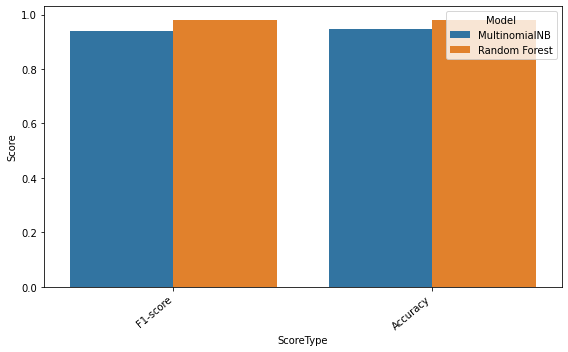

In [25]:
labels = ['MultinomialNB','MultinomialNB','Random Forest', 'Random Forest']
scoreType = ['F1-score','Accuracy','F1-score','Accuracy']
scores = [mnb_f1_score,mnb_accuracy]+[rfc_f1_score,rfc_accuracy]
df_dict = {'Model':labels, 'Score':scores,'ScoreType':scoreType}
df = pd.DataFrame(df_dict)

plt.figure(figsize=(8,5))
ax = sns.barplot(x="ScoreType", y="Score",hue="Model", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Conclusion

The above graphs shows that Random Forest has the higher accuracy and f1-score with a value of 0.98 or 98% . Multinomial NB is also not far behind which gives similar accuracy and f1-score as Random Forest with a value of 0.94 or 94%. 

Thus the optimum classification model to determine if an article is fake news or not is the random forest model